<h1 id="tocheading">TransferWise - Take Home Test (Part A)</h1>
<div id="toc"></div>

### Purpose

The purpose of Part A is to assess how you understand systems, structure problems and generate solutions. 

### Background

One of TransferWise’s main values is transparency – it’s what separates us from the old world of finance. Over time we have learned that transparency is important not only when it comes to price, but also when it comes to the speed of our transfers. We’ve also learned that our customers like to know in advance how long it takes for their money to arrive. Hence we need to estimate the delivery time of their transfer. 
In the real world, delivery time of customer transfer is dependent on a number of things - the source currency and pay-in method used by customer to fund the transfer, payment processing time by TransferWise (KYC and anti-fraud checks, making cash available for payout) and the target currency and payout method used by TransferWise to pay the recipient. 
Your task is to figure out a **concept** for such a “delivery estimator” for one currency corridor. A supportive dataset for that corridor to help you build an estimator that our customers could rely on. 

## Exploratory Data Analysis

**Import statements and Data prep**

In [7]:
import datetime
import time

# import joypy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
df = pd.read_csv('data/transferwise_data.csv')
cols = df.columns
date_cols = cols.drop('payment_method').tolist()

for c in date_cols:
    df[c] = pd.to_datetime(df[c])

**Engineering some new features**

- **creation2receive** - Time it takes from the moment the customer finishes setting up the transfer to when TransferWise fully receives the deposit (hours);
- **receive2conversion** - Time it takes from the moment TransferWise fully receives the deposit by the customer to when it's converted from one currency to another (hours);
- **conversion2emission** - Time it takes from the moment the money is converted to the recipient's currency to the moment TransferWise sends the transfer to the customer (hours);
- **emission2delivery** - Time it takes from the moment TransferWise sends the money  to the customer to when the recipient actually receives it and cand spend it (hours);
- **total_time_in_hours** - Total time in hours it takes for the transfer to be placed by the customer to be available to the recipient

In [9]:
df['creation2receive'] = (df['transfer_received_by_tw_time'] - df['transfer_created_by_customer_time']).dt.total_seconds() / 3600
df['receive2conversion'] = (df['transfer_converted_time'] - df['transfer_received_by_tw_time']).dt.total_seconds() / 3600
df['conversion2emission'] = (df['transfer_sent_out_by_tw_time'] - df['transfer_converted_time']).dt.total_seconds() / 3600
df['emission2delivery'] = (df['transfer_delivered_to_customer_time'] - df['transfer_sent_out_by_tw_time']).dt.total_seconds() / 3600
df['total_time_in_hours'] = df['creation2receive'] + df['receive2conversion'] + df['conversion2emission'] + df['emission2delivery']

df['reference_date'] = df['transfer_created_by_customer_time'].dt.strftime('%Y-%m-%d')
df['reference_month'] = df['transfer_created_by_customer_time'].dt.strftime('%Y-%m')
df['reference_month_name'] = df['transfer_created_by_customer_time'].dt.strftime('%b')
df['reference_weekday'] = df['transfer_created_by_customer_time'].dt.strftime("%A")

df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


transfer_created_by_customer_time transfer_received_by_tw_time  \
0               2015-11-16 09:42:07          2015-11-17 13:50:07   
1               2015-11-06 07:53:02          2015-11-10 11:45:03   
2               2015-07-12 11:56:50          2015-07-14 12:40:01   
3               2015-05-30 16:08:49          2015-06-04 11:55:09   
4               2015-12-23 18:37:16          2015-12-29 13:38:02   

  transfer_converted_time transfer_sent_out_by_tw_time  \
0     2015-11-17 15:35:27          2015-11-17 15:47:03   
1     2015-11-10 11:51:35          2015-11-10 12:18:00   
2     2015-07-15 16:55:37          2015-07-15 17:08:02   
3     2015-06-04 12:36:50          2015-06-04 14:50:42   
4     2015-12-29 13:52:59          2015-12-29 14:01:00   

  transfer_delivered_to_customer_time payment_method  creation2receive  \
0                 2015-11-17 16:02:03              A         28.133333   
1                 2015-11-10 12:33:00              A         99.866944   
2                 2015-07-15 17:23:02              A         48.719722   
3                 2015-06-04 15:05:42              A        115.772222   
4                 2015-12-29 14:16:00              A        139.012778   

   receive2conversion  conversion2emission  emission2delivery  \
0            1.755556             0.193333               0.25   
1            0.108889             0.440278               0.25   
2           28.260000             0.206944               0.25   
3            0.694722             2.231111               0.25   
4            0.249167             0.133611               0.25   

   total_time_in_hours reference_date reference_month reference_month_name  \
0            30.332222     2015-11-16         2015-11                  Nov   
1           100.666111     2015-11-06         2015-11                  Nov   
2            77.436667     2015-07-12         2015-07                  Jul   
3           118.948056     2015-05-30         2015-05                  May   
4           139.645556     2015-12-23         2015-12                  Dec   

  reference_weekday  
0            Monday  
1            Friday  
2            Sunday  
3          Saturday  
4         Wednesday

In [152]:
df.groupby('payment_method').describe()

creation2receive                                             \
                          count       mean        std       min        25%   
payment_method                                                               
A                        2765.0  66.862060  44.484335  0.631667  41.103611   
B                         115.0   2.932853  15.259887  0.004722   0.017500   
C                         120.0  52.739898  79.765069  0.000000   0.000278   

                                                 receive2conversion  \
                      50%        75%         max              count   
payment_method                                                        
A               49.770278  88.844167  764.324444             2765.0   
B                0.027500   0.064583  117.162500              115.0   
C               41.033333  68.361944  590.416389              120.0   

                           ... emission2delivery       total_time_in_hours  \
                     mean  ...               75%   max               count   
payment_method             ...                                               
A                5.276006  ...              0.25  0.25              2765.0   
B                2.076836  ...              0.25  0.25               115.0   
C               13.817493  ...              0.25  0.25               120.0   

                                                                       \
                     mean         std       min        25%        50%   
payment_method                                                          
A               73.021260   62.740716  5.528056  42.834722  52.174167   
B                6.656744   16.395224  0.420833   0.741250   1.020833   
C               67.064002  176.672344  0.250278   0.251319  41.975972   

                                        
                      75%          max  
payment_method                          
A               91.883056  1839.421667  
B                6.366667   118.069444  
C               70.815278  1836.529444  

[3 rows x 40 columns]

### Correlations


When we explore a little bit the correlations between the variables that we just created, we see that the time between each process is fairly independent from one another and a huge chunk of the delivery time is spent on the **creation2receive** and **receive2conversion** steps, since they have the bigger correlations with **total_time_in_hours**. 

P.S: **emission2delivery** is all greyed out because it is a constant (15 minutes).

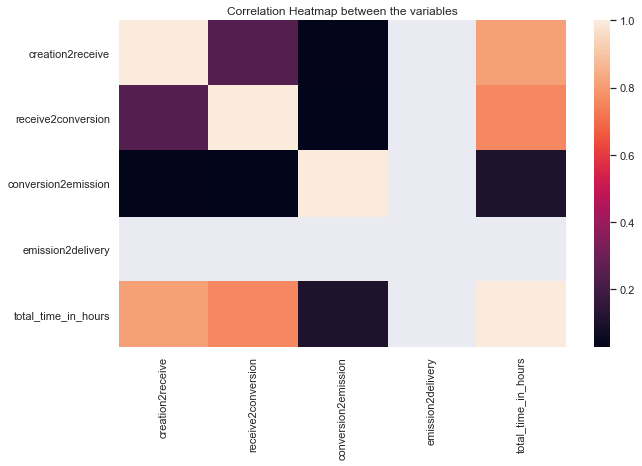

In [151]:
sns.set(rc={'figure.figsize':(10, 6)})
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns
);

plt.title("Correlation Heatmap between the variables");

### Time in hours from creation to receivement by payment method

Time it takes from the moment the customer finishes setting up the transfer to when TransferWise fully receives the deposit. The plot below show huge variance on payment methods A and C, unlike payment method B, which, so far, seems to be the fastest one.

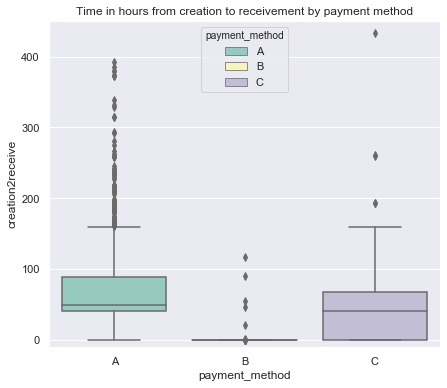

In [111]:
sns.set(rc={'figure.figsize':(7, 6)})

ax = sns.boxplot(
    data=df.sort_values('payment_method'),
    x='payment_method',
    y='creation2receive',
    hue='payment_method',
    orient='v',
    palette="Set3",
    dodge=False
)

ax.set(ylim=[-10, 450])
ax.set(title="Time in hours from creation to receivement by payment method");

### Time in hours from receivement to conversion by payment method

Time it takes from the moment TransferWise fully receives the deposit by the customer to when it's converted from one currency to another.

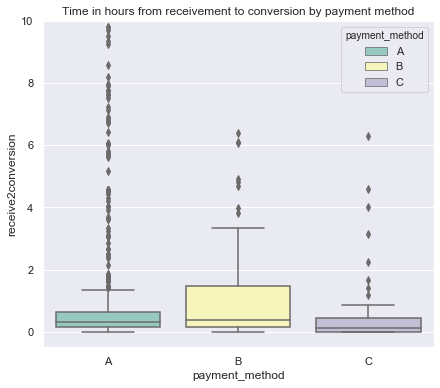

In [94]:
sns.set(rc={'figure.figsize':(7, 6)})

ax = sns.boxplot(
    data=df.sort_values('payment_method'),
    x='payment_method',
    y='receive2conversion',
    hue='payment_method',
    orient='v',
    palette="Set3",
    dodge=False
)

ax.set(ylim=[-0.5, 10])
ax.set(title="Time in hours from receivement to conversion by payment method");

### Time in hours from conversion to sending by payment method

Time it takes from the moment the money is converted to the recipient's currency to the moment TransferWise sends the transfer to the customer. Payment method B has a similar median when compared to the other methods, but a fairly higher variance, but, overall, this is one of the fastest steps, since the median is around 10-15 minutes.

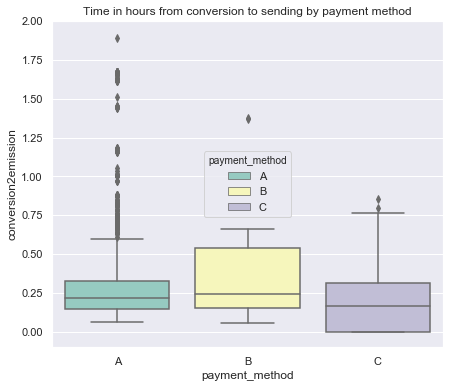

In [116]:
sns.set(rc={'figure.figsize':(7, 6)})

ax = sns.boxplot(
    data=df.sort_values('payment_method'),
    x='payment_method',
    y='conversion2emission',
    hue='payment_method',
    orient='v',
    palette="Set3",
    dodge=False
)

ax.set(ylim=[-0.1, 2])
ax.set(title="Time in hours from conversion to sending by payment method");

### Time in hours from sending to delivery to the recipient by payment method

Time it takes from the moment TransferWise sends the money  to the customer to when the recipient actually receives it and cand spend it. This is a constant of 0.25 hour (15 minutes). Doesn't change with time or payment method.

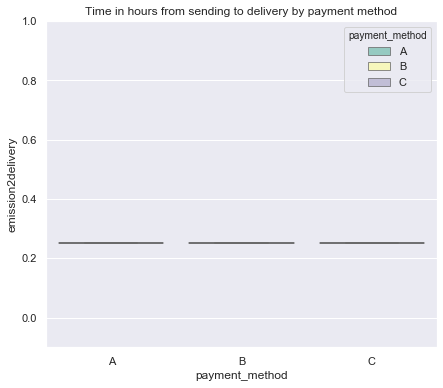

In [277]:
sns.set(rc={'figure.figsize':(7, 6)})

ax = sns.boxplot(
    data=df.sort_values('payment_method'),
    x='payment_method',
    y='emission2delivery',
    hue='payment_method',
    orient='v',
    palette="Set3",
    dodge=False
)

ax.set(ylim=[-0.1, 1])
ax.set(title="Time in hours from sending to delivery by payment method");

### Total transfer time in hours by payment method

Total time it takes for the transfer to be placed by the customer to be available to the recipient. Payment methods A and C are the slowest ones, while B is the fastest by a large margin. 

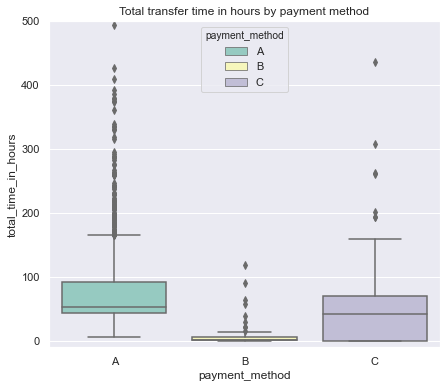

In [69]:
sns.set(rc={'figure.figsize':(7, 6)})

#Total time in hours
ax = sns.boxplot(
    data=df.sort_values('payment_method'),
    x='payment_method',
    y='total_time_in_hours',
    hue='payment_method',
    orient='v',
    palette="Set3",
    dodge=False
)

ax.set(ylim=[-10, 500])
ax.set(title="Total transfer time in hours by payment method");

### Transfer time distributions over time

#### Total time in hours over the year of 2015

The chart below shows that the distributions of delivery time did not change drastically across the months of 2015, apart from the month of January, that exhibited a very different distribution, with a big standard deviation. The later months of the year, with the introduction and adoption of the payment method B by more customers, the distribution was getting slowly narrower, meaning that the average total delivery time was getting shorter

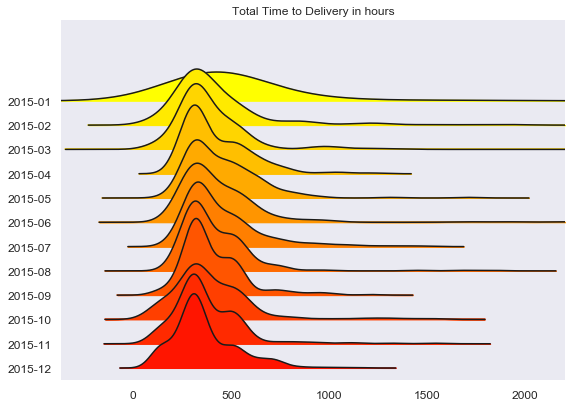

In [160]:
fig, axes = joypy.joyplot(df.sort_values('reference_date'), 
                          by="reference_month", 
                          column="total_time_in_hours",
                          range_style='own',
                          legend=False, 
                          figsize=(7, 5),
                          title="Total Time to Delivery in hours",
                          colormap=plt.cm.autumn_r
 )

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
for a in axes[:-1]:
    a.set_xlim([-120,500])

#### Average total transfer time in hours per payment method over 2015

Payment method C shows huge confidence intervals and, could indicate some seasonality during the months of June and July

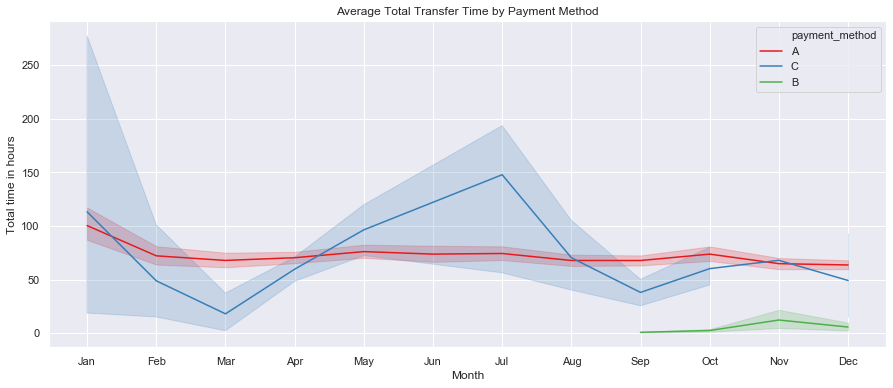

In [211]:
sns.set(rc={'figure.figsize':(15, 6)})
ax = sns.lineplot(data=df.sort_values('reference_date'),
                  x="reference_month_name",
                  y="total_time_in_hours",
                  hue="payment_method",
                  sort=False,
                  palette='Set1',
                  legend="full",
                 )

ax.set(title="Average Total Transfer Time by Payment Method", 
       ylabel="Total time in hours",
       xlabel="Month"
      );

#### Average total transfer time in hours per weekday over 2015

When the transfer is set up by the customer on Thursdays, Fridays or Saturdays it takes more time than usual, so business days are a important factor.

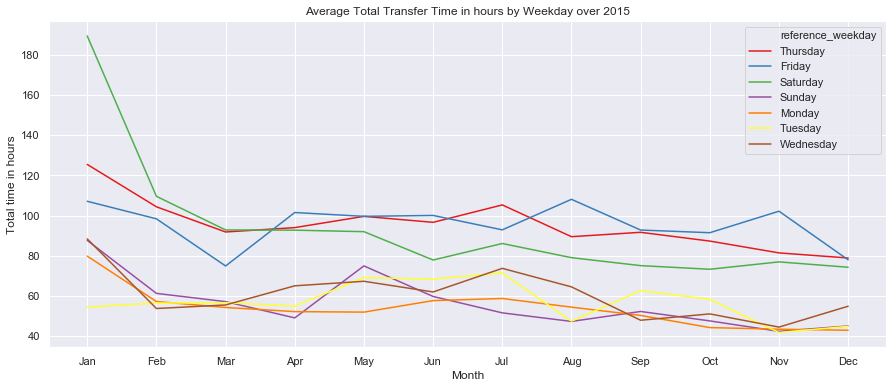

In [207]:
sns.set(rc={'figure.figsize':(15, 6)})
ax = sns.lineplot(data=df.sort_values('reference_date'),
                  x="reference_month_name",
                  y="total_time_in_hours",
                  hue="reference_weekday",
                  sort=False,
                  palette='Set1',
                  legend="full",
                  ci=None
                 )

ax.set(title="Average Total Transfer Time in hours by Weekday over 2015", 
       ylabel="Total time in hours",
       xlabel="Month"
      );

#### Total amount of transactions per payment method over the year

Transfers made with payment method A makes up for the majority of transfers made during the year. Very few transactions with payment method C might explain the huge variance seen on the plots above around the months of June and July

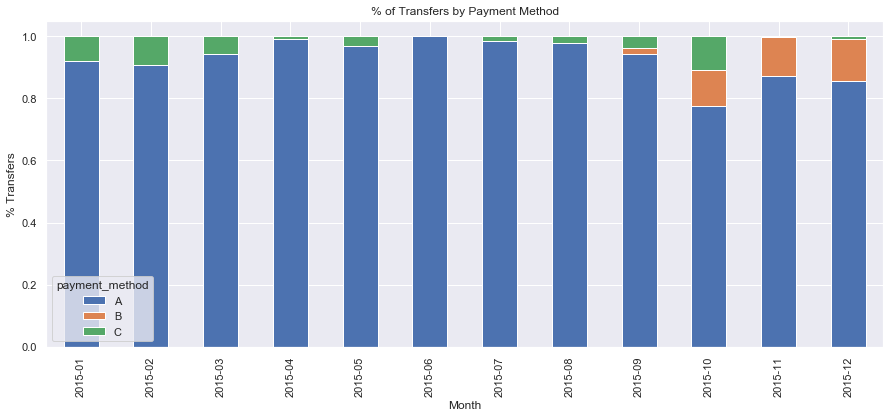

In [223]:
sns.set(rc={'figure.figsize':(15, 6)})

df_pct = (df.groupby(['reference_month','payment_method'])['transfer_created_by_customer_time'].count()/df.groupby(['reference_month'])['transfer_created_by_customer_time'].count())

ax = df_pct.unstack().plot.bar(stacked=True);

ax.set(xlabel='Month',
       ylabel='% Transfers',
       title="% of Transfers by Payment Method"
      );

## Questions

### What does your delivery estimation algorithm look like? 
If a customer goes on TransferWise.com on the 18th of July, when will their money arrive? How about on the 23rd of December?


**Answer**: <br>
I ended up choosing to use a forecasting procedure for time-series data. After some approaches to solve this problem with linear models, I realized I needed an algorithm a bit more robust with seasonal data and that could better handle the outliers on the dataset provided.
<br> With that in mind, I chose to use **Prophet** by Facebook, since it's fast and provides automated forecasts that can be fine-tuned by hand.


In [155]:
from sklearn.preprocessing import LabelEncoder
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly, plot_cross_validation_metric
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline


df_p = df[['total_time_in_hours', 'reference_date', 'payment_method']]

le = LabelEncoder()
df_p.iloc[:,2] = le.fit_transform(df_p.iloc[:,2])

X= df_p[['reference_date', 'payment_method']] #dates and regressor
y= df_p['total_time_in_hours'] #response-variable (I wanna be able to predict the total delivery time in hours)

#Payment method Encoding
# 0 - A
# 1 - B
# 2 - C

# Declaring holidays we might want to track on our model
holidays = pd.DataFrame({
    'holiday': 'Holidays Season',
    'ds': pd.to_datetime(['2015-12-25', '2016-12-25', '2015-01-01', '2016-01-01']),
    'lower_window': -2,
    'upper_window': 0
}
)


train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["reference_date"])
train_dataset['y']=y
train_dataset.head()



ds           y
0 2015-11-16   30.332222
1 2015-11-06  100.666111
2 2015-07-12   77.436667
3 2015-05-30  118.948056
4 2015-12-23  139.645556

#### Fitting the model

I chose to use `yearly_seasonality=True` because of the behaviour in January, but it should really be confirmed if that's a recurring behavior or something specific that happened in 2015. 

In [156]:
model = Prophet(yearly_seasonality=True, holidays=holidays)
model.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



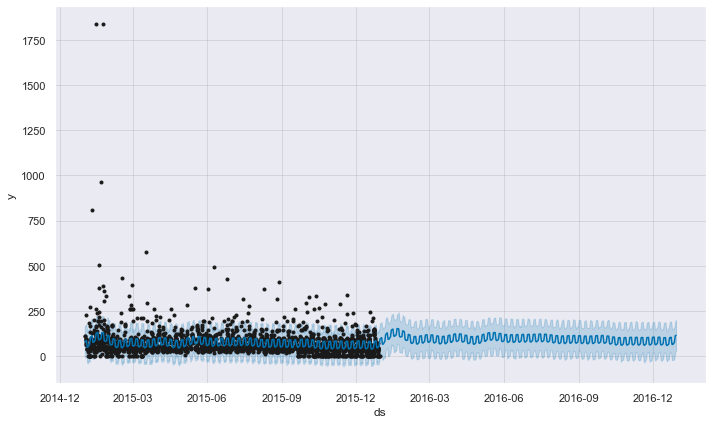

In [157]:
future= model.make_future_dataframe(periods=365) #predicting 365 days in advance
forecast=model.predict(future)

fig1 = model.plot(forecast)


Above, we have the black dots as the real data from the dataset. The blue line is the `y-hat` predicted and the blue area is the confidence interval of the prediction. Since I chose yearly seasonality, we can see that there's a small bump on the delivery time predicted during the month of January.

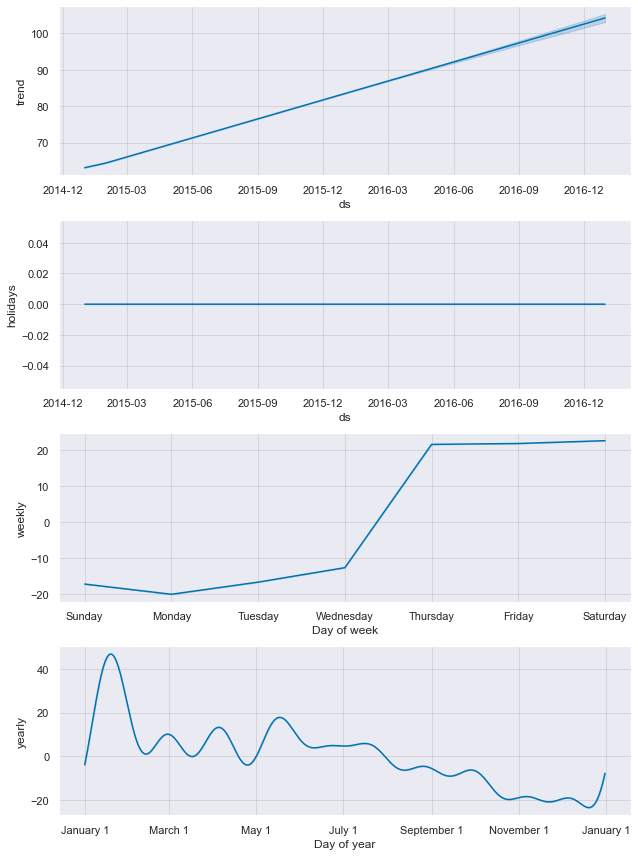

In [158]:
fig2 = model.plot_components(forecast)

Here we can see that the holidays that we added doesn't seem to be very important to the algorithm, playing almost no influence on the predictions. <br>
We can also see that the weekly seasonality is huge! As noted before on our EDA, the transfer being initiated on Thursdays, Friday and Saturday can increase, on average, 20 hours on our delivery estimate. <br>
Variation between the months also seem to be relevant, especially around January and late in the year, where the transfers appear to be concluded 20 hours faster, on average.

#### Adding a regressor

Since we have the payment method variable, we can add to the predictions in order to increase the accuracy of our model. To do that, we will add the variable and split the dataset in train/test and then cross-validate it.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



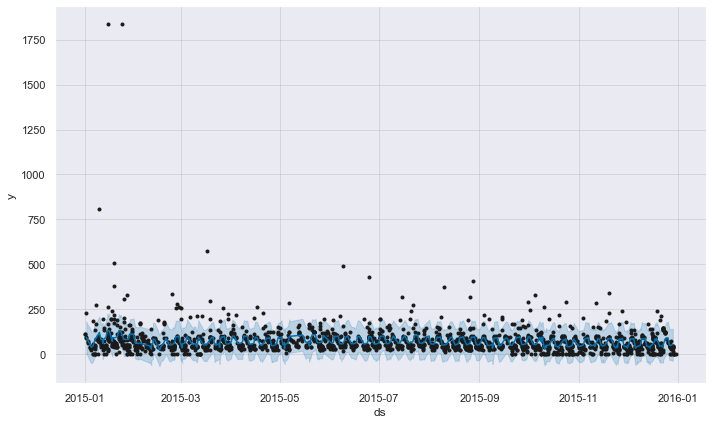

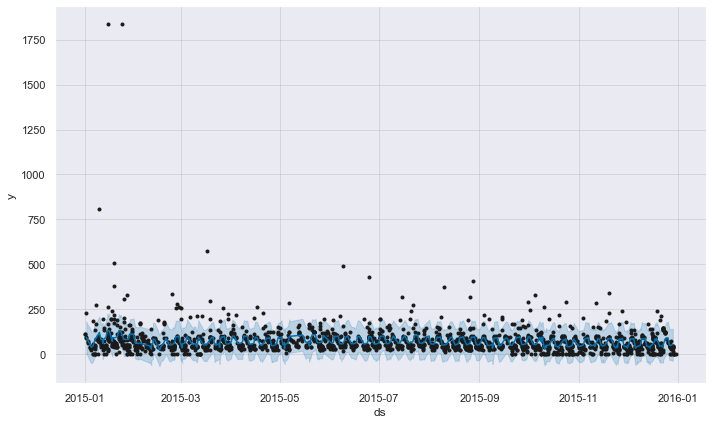

In [159]:
train_dataset['payment_method'] = X['payment_method']
train_X= train_dataset[:2400]
test_X= train_dataset[2400:]


model_regressor = Prophet(yearly_seasonality=True, holidays=holidays)
model_regressor.add_regressor('payment_method')
model_regressor.fit(train_X)
future_data = model_regressor.make_future_dataframe(periods=365)
forecast_data = model_regressor.predict(test_X)

#### Cross-Validation

Now, the predictions seem to conform a lot more with the real data. Let's cross-validate. <br>
Here we do cross-validation to assess prediction performance on a horizon of 300 days, starting with 30 days of training data in the first cutoff and then making predictions every 90 days. I'll use the mean absolute percent error (MAPE) metric, which measures the percent error for every point predicted on the test dataset. Below, the plot is showing the error % increasing as we increase the horizon window. In other words, the further in the future we are trying to predict (+300 days, for instance), the bigger the margin of error. In this case, we are going from 1-2% to 8% as we hit 275 days of the horizon window.

INFO:fbprophet:Making 1 forecasts with cutoffs between 2015-03-06 00:00:00 and 2015-03-06 00:00:00
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



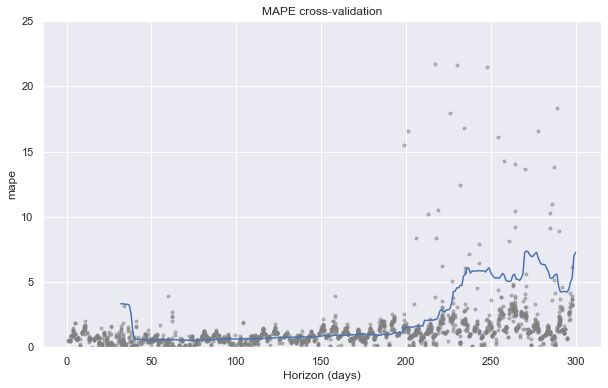

In [172]:
df_cv = cross_validation(pro_regressor, initial='30 days', period='90 days', horizon='300 days')
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim([0, 25]);
plt.title("MAPE cross-validation");

#### Predictions - 2016-07-18 and 2016-12-23

We are gonna use the model developed above to predict the delivery time for transfers made on **2016-07-18** and **2016-12-23**. <br><br>
For someone that goes to TransferWise website on 2016-07-23 (Monday), these would be the predictions for each payment method selected:

- **Payment Method A**: 79.44 hours or 3 days and 7 hours (Delivery by 2016-07-21)
- **Payment Method B**: 68.18 hours or 2 days and 20 hours (Delivery by 2016-07-20)
- **Payment Method C**: 56.92 hours or 2 days and 9 hours (Delivery by 2016-07-20)

<br><br>
For someone that goes to TransferWise website on 2016-12-23 (Friday), these would be the predictions for each payment method selected:

- **Payment Method A**: 104.33 hours or 4 days and 8 hours (Delivery by 2016-12-27)
- **Payment Method B**: 93.07 hours or 3 days and 21 hours (Delivery by 2016-12-26)
- **Payment Method C**: 81.80 hours or 3 days and 10 hours (Delivery by 2016-12-26)

In [147]:
dict_pred = [
    {
        'ds': ['2016-07-18'],
        'payment_method': [0],
        'payment_method_code': ['A']
    },
    {
        'ds': ['2016-07-18'],
        'payment_method': [1],
        'payment_method_code': ['B']
    },
    {
        'ds': ['2016-07-18'],
        'payment_method': [2],
        'payment_method_code': ['C']
    },
    {
        'ds': ['2016-12-23'],
        'payment_method': [0],
        'payment_method_code': ['A']
    },
    {
        'ds': ['2016-12-23'],
        'payment_method': [1],
        'payment_method_code': ['B']
    },
    {
        'ds': ['2016-12-23'],
        'payment_method': [2],
        'payment_method_code': ['C']
    }
]

final_predictions = []
for p in dict_pred:
    pred = pd.DataFrame.from_dict(p, orient='columns')
    prediction = pro_regressor.predict(pred[['ds', 'payment_method']])
    p['ds'] = p['ds'][0]
    p['payment_method'] = p['payment_method'][0]
    p['payment_method_code'] = p['payment_method_code'][0]
    p['yhat'] = prediction['yhat'].values[0]
    p['yhat_lower'] = prediction['yhat_lower'].values[0]
    p['yhat_upper'] = prediction['yhat_upper'].values[0]
    final_predictions.append(p)

final_predictions_df = pd.DataFrame.from_dict(final_predictions, orient='columns')
final_predictions_df

ds  payment_method payment_method_code        yhat  yhat_lower  \
0  2016-07-18               0                   A   79.448340  -10.874042   
1  2016-07-18               1                   B   68.184980  -21.761751   
2  2016-07-18               2                   C   56.921620  -25.389877   
3  2016-12-23               0                   A  104.335955   10.569236   
4  2016-12-23               1                   B   93.072594   10.729181   
5  2016-12-23               2                   C   81.809234  -10.447326   

   yhat_upper  
0  169.613644  
1  156.332126  
2  146.659790  
3  195.255978  
4  175.546188  
5  169.515756

**ds** - Day of prediction <br>
**payment_method** - payment method encoded <br>
**payment_method_code** - real payment method (A, B, C) <br>
**yhat** - actual prediction of `total_time_in_hours` <br>
**yhat_lower** - prediction's Confidence Interval lower boundary <br>
**yhat_upper** - predictions' Confidence Interval upper boundary <br>

### What happens if you miss the estimate? What happens if you’re too conservative? 

A wrong delivery estimate could lead to a bad experience with TransferWise's product by the customer. If the delivery is late, the customer would, most likely, reach customer support and maybe even ask for refunds. If we are too conservative, although it is less harmful than being late, it could dissuade the customer from making the transfer, since it might not fit his timeline.

### Where and how would you communicate the estimator to our customer? 

It would have to be communicated on the first step, as soon as he sees the first calculator on the website, allowing him to make an well-informed decision regarding his own money. <br>
The estimate should be conditioned to the payment method selected. Also, the quickest payment method should be the default value. <br>
At last, I would really like to test an hypothesis where we can show the customers messages like this:
<br><br>
`Want your money by Friday July 21st? Transfer in the next 3 hours and 17 minutes to make it in time`
<br><br>
The goal would be to measure if we can create some sense of urgency to the customer and make sure he will finish the transfer.

### What is the minimum viable product (MVP) that you could build with four developers in 48 hours to validate your estimator? 

The MVP could be as simple as a dataset with the predictions of the next 60 days from the Prophet model above, we wouldn't have to deploy a live machine-learning model on the cloud right away. Hopefully, for testing purposes, the development team could upload this single pre-calculated base of dates, payment methods and expected delivery time

### How would you measure the success of your estimator?

For this project, I believe success would have to be measure with these 3 basic KPIs:
    
- **% prediction accuracy**: Are we predicting the correct delivery time? Are they early, on-time or late?
- **% customer conversion**: Are we being too conservative and scaring the customers off with huge time estimates? 
- **% contacts regarding delivery status**: If the estimate is late, the customer will probably try to contact the support team. Can the new estimator keep that down?

In [174]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>